In [20]:
import os
from pathlib import Path
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from lib.city_blocks import load_street_graph, remove_deadends, city_blocks
from lib.config import tmp_folder_path
%matplotlib inline  

## Intro
This is a notebook that shows how to find city blocks from a street graph. The main code used in this notebook is found in `city_blocks.py`

## Settings

In [40]:
### Area settings
a_name = 'nakano'
radius = 2500
coords_nakano = (35.6059402,139.6664317)
network_type = 'drive'

### Speed-up settings
remove_road_curves = True
remove_dead_ends = True
cityblock_use_cached = False

data_prefix = '{}-{}-{}'.format(a_name, radius, network_type)

## Load street graph
Use cached data if available, otherwise download first and then save to disk.  
NOTE: This will take a while if a large radius is used! 

In [22]:
street_graph = load_street_graph(coords=coords_nakano, 
                                 radius=radius, 
                                 network_type=network_type,
                                 filename=data_prefix+'.graphml')

restoring full street graph from disk


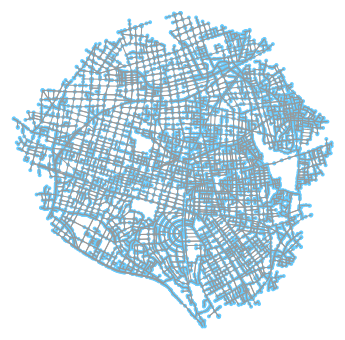

In [23]:
ox.plot_graph(street_graph);

## Simplify graph using `osmnx` simplification
Removes nodes to join edges that make up road curves. Note that doing this will affect the resulting city blocks. This is can be ammended by a different implementation. 

In [24]:
if remove_road_curves:
    street_graph = ox.simplify_graph(street_graph)

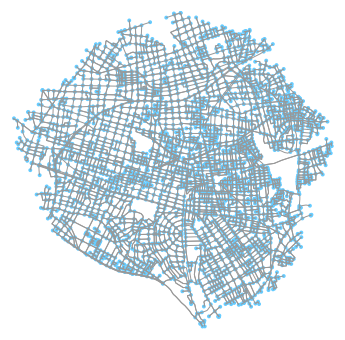

In [25]:
ox.plot_graph(street_graph);

## Simplify graph by removing dead-end roads
Removing the dead-end roads does not affect the shape of the city blocks. 

In [26]:
if remove_dead_ends:
    street_graph = remove_deadends(street_graph)

We need to check that there's any street network left after applying our simplifications:

In [27]:
assert len(street_graph) > 0

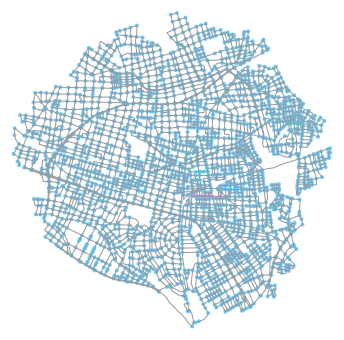

In [28]:
ox.plot_graph(street_graph);

Plotting the simplified graph in folium is handy for inspecting local areas. Slow for large areas. 

In [29]:
#ox.plot_graph_folium(street_graph)

## Calculate city blocks

In [30]:
blocks = city_blocks(street_graph)

100%|██████████| 10048/10048 [00:15<00:00, 636.42it/s]


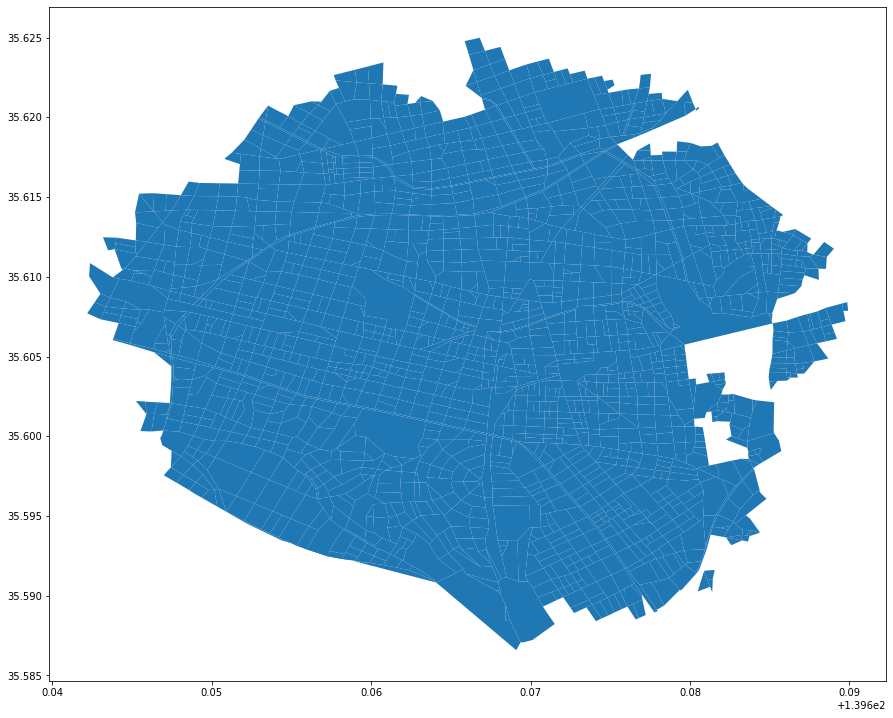

In [31]:
blocks.plot(figsize=(15,15));

In [32]:
print('number of areas: {}'.format(len(blocks)))

number of areas: 1888


## Dealing with invalid polygons

When calculating city blocks for larger areas, it will often happen that some of the polygons representing the city blocks are invalid. This means that the polygons are complex and have self-intersections. We can deal with this by applying some shapely magic.  

First, we find the invalid polygons and plot them.

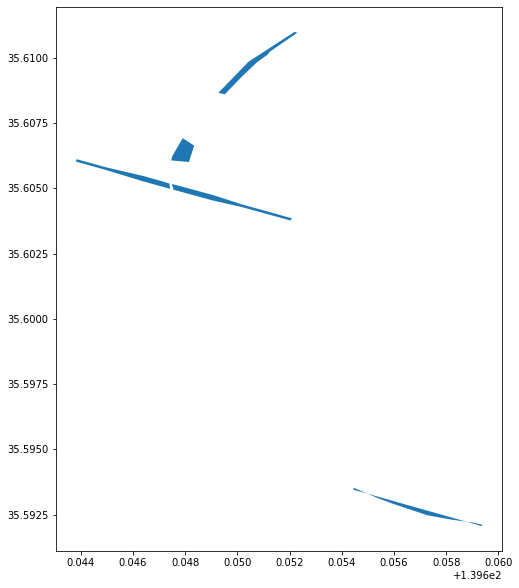

In [33]:
invalid = blocks[blocks.is_valid == False]
if not invalid.empty: 
    invalid.plot(figsize=(10,10))

Fix polygons and create second dataframe

In [34]:
fixed = [ ]
for _,pol in invalid.geometry.iteritems():
    pol = pol.buffer(0)
    if isinstance(pol, MultiPolygon):
        for p in pol.geoms:
            fixed.append(p)
    else:
        fixed.append(pol)
fixed = gpd.GeoDataFrame({'geometry':fixed})
       

In [35]:
blocks = blocks[blocks.is_valid == True]
blocks = blocks.append(fixed)
blocks.reset_index(inplace=True, drop=True)

And voila!

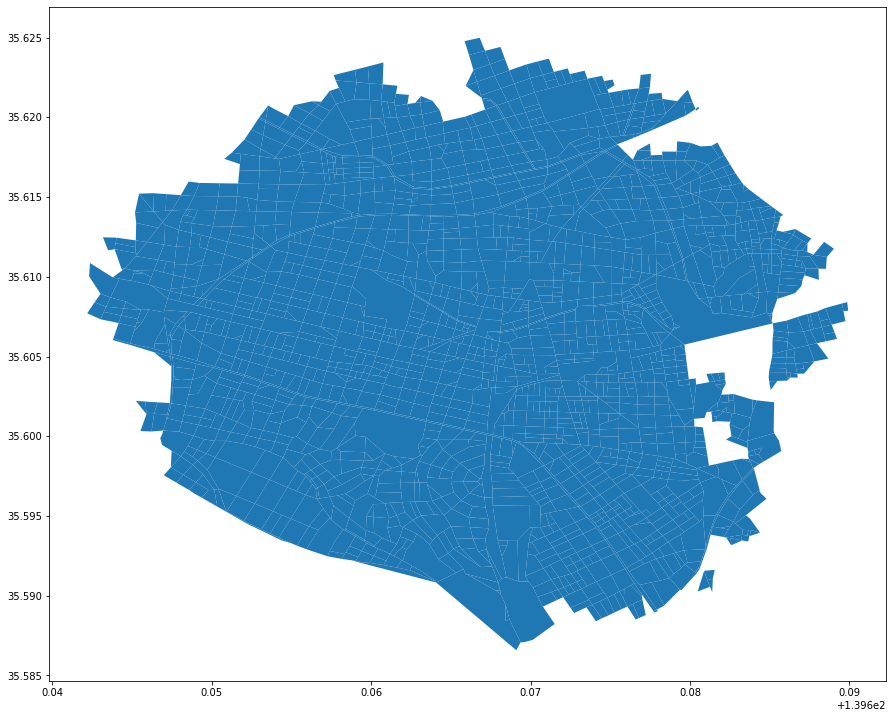

In [36]:
blocks.plot(figsize=(15,15));

In [37]:
blocks.to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[139.6778527, 35.6101311], [139.6779101, 35.6101668], [139.6779118, 35.610119], [139.6778527, 35.6101311]]]}}, {"id": "1", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[139.6779101, 35.6101668], [139.6778828, 35.6109555], [139.67842, 35.6104537], [139.6779101, 35.6101668]]]}}, {"id": "2", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[139.6824129, 35.5941514], [139.6819048, 35.594249], [139.6825604, 35.5943818], [139.6824129, 35.5941514]]]}}, {"id": "3", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[139.6734149, 35.6038524], [139.6733619, 35.6034423], [139.6729915, 35.603472], [139.6734149, 35.6038524]]]}}, {"id": "4", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[139.6741087, 35.603864

## Save areas as GeoJson

In [47]:
geofile = Path('./', data_prefix).with_suffix('.geojson')

with open(geofile, 'w+') as af: 
    af.write(blocks.to_json())

Geojson file size in MiB:

In [48]:
os.path.getsize(geofile.as_posix())/2**20

0.48371028900146484